In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

if torch.cuda.is_available():
    device = "cuda"
elif torch.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device

'cuda'

In [2]:
class nfl_dataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        
        if self.transform:
            sample = self.transform(sample)
        
        sample = torch.tensor(sample, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)
        
        return sample, target

In [11]:
class MDN(nn.Module):
    def __init__(self, input_size, hidden_layers, num_gaussians, dropout_rate):
        super(MDN, self).__init__()
        
        # hyperparameters
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.num_gaussians = num_gaussians
        
        # convert hidden layer parameters to linear layers
        layers = []
        layer_sizes = [input_size] + hidden_layers
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
        self.hidden_layers_net = nn.ModuleList(layers)
        
        # relu and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        
        # mixture distribution layers
        self.pi_layer = nn.Linear(64, num_gaussians)
        self.mu_layer = nn.Linear(64, num_gaussians)
        self.sigma_layer = nn.Linear(64, num_gaussians)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):

        for layer in self.hidden_layers_net:
            x = layer(x)
            x = self.relu(x)
            x = self.dropout(x)
        
        pi = self.softmax(self.pi_layer(x))
        mu = self.mu_layer(x)
        
        # stabilize sigma computation
        sigma_raw = self.sigma_layer(x)
        sigma = torch.nn.functional.softplus(torch.clamp(sigma_raw, -10, 10)) + 1e-6
        
        return pi, mu, sigma
    
    def mdn_loss(self, pi, mu, sigma, target):
        log_2pi = torch.log(2 * torch.pi * sigma**2)
        log_gaussian = -0.5 * (log_2pi + ((target - mu) / sigma) ** 2)
        weighted_log_probs = torch.log(pi + 1e-8) + log_gaussian
        log_likelihood = torch.logsumexp(weighted_log_probs, dim=1)
        loss = -log_likelihood.mean()
        
        return loss

In [12]:
def train_model(model, train_loader, test_loader, optimizer, num_epochs, device):
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            pi, mu, sigma = model(data)
            loss = model.mdn_loss(pi, mu, sigma, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                pi, mu, sigma = model(data)
                loss = model.mdn_loss(pi, mu, sigma, target)
                test_loss += loss.item()
        
        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses
        

In [13]:
# load in data
data_path = r'C:\Users\Jona\Desktop\tuxff\tuxff-models\data\data_mdn.csv'
data = pd.read_csv(data_path, delimiter=',')

# train test split data
features = data.iloc[:, 2:-1]
targets = data.iloc[:, -1:]
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# scaled x data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# scale y data
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# create dataset
train_dataset = nfl_dataset(X_train_scaled, y_train_scaled)
test_dataset = nfl_dataset(X_test_scaled, y_test_scaled)

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

X_train_scaled.shape

(17872, 65)

Epoch 0/201, Train Loss: 1.2066, Test Loss: 0.9289
Epoch 10/201, Train Loss: 0.7933, Test Loss: 0.7142
Epoch 20/201, Train Loss: 0.7263, Test Loss: 0.6720
Epoch 30/201, Train Loss: 0.6868, Test Loss: 0.6281
Epoch 40/201, Train Loss: 0.6460, Test Loss: 0.6155
Epoch 50/201, Train Loss: 0.6160, Test Loss: 0.6005
Epoch 60/201, Train Loss: 0.5880, Test Loss: 0.5860
Epoch 70/201, Train Loss: 0.5843, Test Loss: 0.5702
Epoch 80/201, Train Loss: 0.5765, Test Loss: 0.5581
Epoch 90/201, Train Loss: 0.5732, Test Loss: 0.5556
Epoch 100/201, Train Loss: 0.5699, Test Loss: 0.5791
Epoch 110/201, Train Loss: 0.6043, Test Loss: 0.5348
Epoch 120/201, Train Loss: 0.6421, Test Loss: 0.6465
Epoch 130/201, Train Loss: 0.6377, Test Loss: 0.5992
Epoch 140/201, Train Loss: 0.6364, Test Loss: 0.6362
Epoch 150/201, Train Loss: 0.6246, Test Loss: 0.6199
Epoch 160/201, Train Loss: 0.6267, Test Loss: 0.6432
Epoch 170/201, Train Loss: 0.6207, Test Loss: 0.6439
Epoch 180/201, Train Loss: 0.6111, Test Loss: 0.6428
Epoc

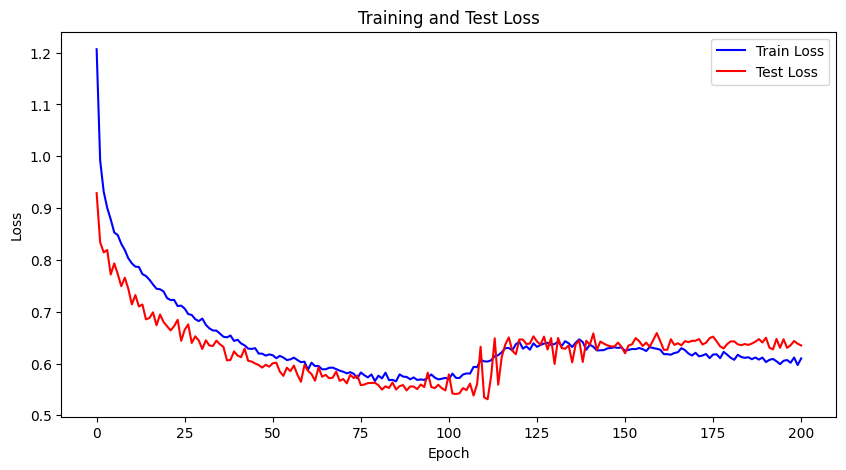

In [17]:
input_size = 65
hidden_layers = [256, 128, 64]
num_gaussians = 3
dropout = 0.5
lr = 0.0001

model = MDN(65, [256, 128, 64], 3, 0.5).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

num_epochs = 201
train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, num_epochs, device)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()